# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concated_layer = layers.concatenate([small_ip_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concated_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    filters = {
        "ec1": 16,
        "ec2": 32,
        "ec3": 64,
        "obo": 128,
        "dc1": 64,
        "dc2": 32,
        "dc3": 16
    }
    
    stride_ec = 1
    
    # ec layer 1
    encoded_layer_1 = encoder_block(inputs, filters["ec1"], stride_ec)
    
    # ec layer 2
    encoded_layer_2 = encoder_block(encoded_layer_1, filters["ec2"], stride_ec)
    
    # ec layer 3
    encoded_layer_3 = encoder_block(encoded_layer_2, filters["ec3"], stride_ec)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1by1_layer = conv2d_batchnorm(encoded_layer_3, filters["obo"], kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    # dc layer 1
    # concat with ec layer 3
    decoded_layer_1 = decoder_block(conv_1by1_layer, encoded_layer_3, filters["dc1"])
    
    # dc layer 2
    # concat with ec layer 2
    decoded_layer_2 = decoder_block(decoded_layer_1, encoded_layer_2, filters["dc2"])
    
    # dc layer 3
    # concat with ec layer 1
    decoded_layer_3 = decoder_block(decoded_layer_2, encoded_layer_1, filters["dc3"])
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decoded_layer_3)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 64
num_epochs = 75
steps_per_epoch = 65
validation_steps = 50
workers = 8

Epoch 1/75
64/65 [============================>.] - ETA: 2s - loss: 0.9083

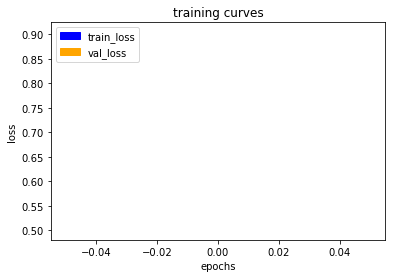

65/65 [==============================] - 191s - loss: 0.9025 - val_loss: 0.5012
Epoch 2/75
64/65 [============================>.] - ETA: 2s - loss: 0.2344

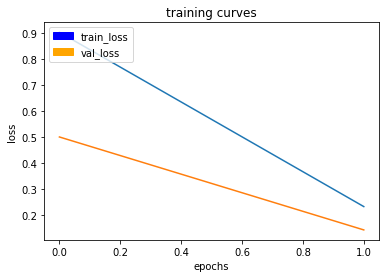

65/65 [==============================] - 187s - loss: 0.2323 - val_loss: 0.1432
Epoch 3/75
64/65 [============================>.] - ETA: 2s - loss: 0.0779

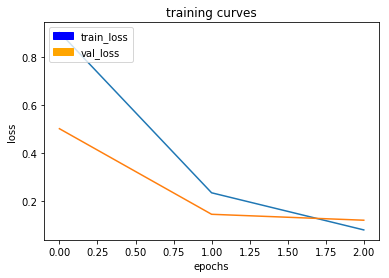

65/65 [==============================] - 188s - loss: 0.0778 - val_loss: 0.1184
Epoch 4/75
64/65 [============================>.] - ETA: 2s - loss: 0.0587

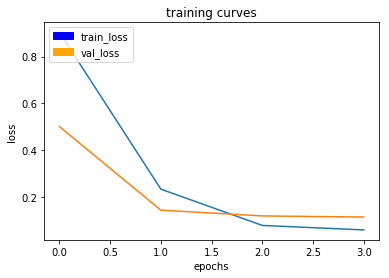

65/65 [==============================] - 188s - loss: 0.0586 - val_loss: 0.1137
Epoch 5/75
64/65 [============================>.] - ETA: 2s - loss: 0.0511

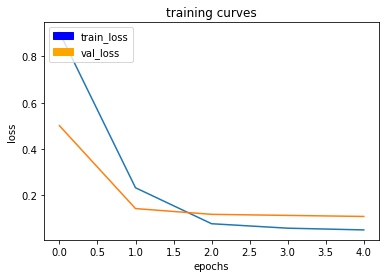

65/65 [==============================] - 188s - loss: 0.0511 - val_loss: 0.1093
Epoch 6/75
64/65 [============================>.] - ETA: 2s - loss: 0.0468

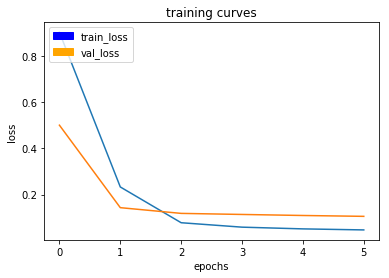

65/65 [==============================] - 188s - loss: 0.0468 - val_loss: 0.1055
Epoch 7/75
64/65 [============================>.] - ETA: 2s - loss: 0.0440

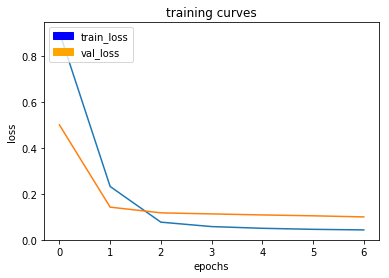

65/65 [==============================] - 188s - loss: 0.0441 - val_loss: 0.1007
Epoch 8/75
64/65 [============================>.] - ETA: 2s - loss: 0.0416

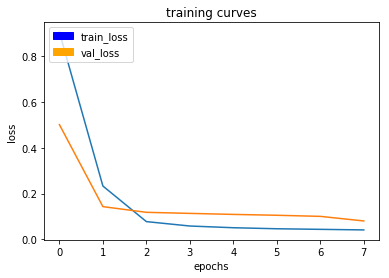

65/65 [==============================] - 188s - loss: 0.0415 - val_loss: 0.0807
Epoch 9/75
64/65 [============================>.] - ETA: 2s - loss: 0.0396

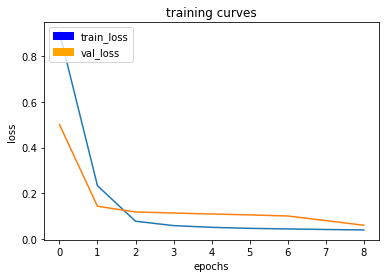

65/65 [==============================] - 188s - loss: 0.0398 - val_loss: 0.0601
Epoch 10/75
64/65 [============================>.] - ETA: 2s - loss: 0.0388

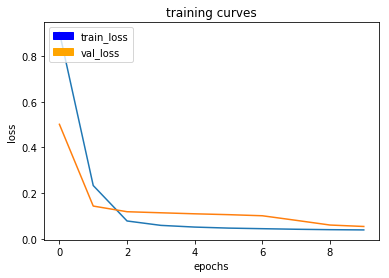

65/65 [==============================] - 188s - loss: 0.0387 - val_loss: 0.0538
Epoch 11/75
64/65 [============================>.] - ETA: 2s - loss: 0.0383

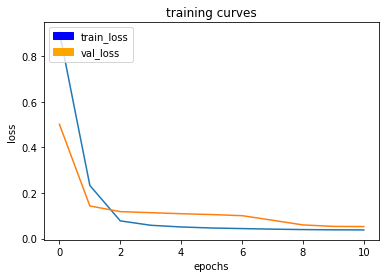

65/65 [==============================] - 188s - loss: 0.0382 - val_loss: 0.0529
Epoch 12/75
64/65 [============================>.] - ETA: 2s - loss: 0.0370

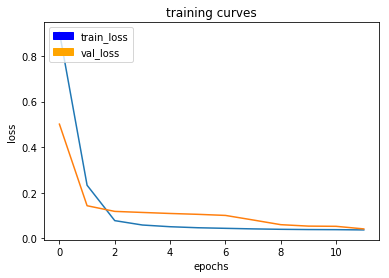

65/65 [==============================] - 188s - loss: 0.0371 - val_loss: 0.0415
Epoch 13/75
64/65 [============================>.] - ETA: 2s - loss: 0.0366

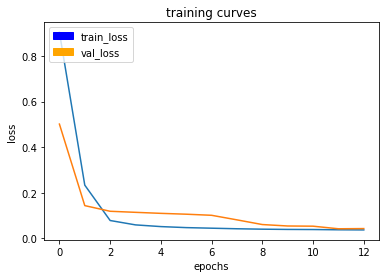

65/65 [==============================] - 189s - loss: 0.0365 - val_loss: 0.0424
Epoch 14/75
64/65 [============================>.] - ETA: 2s - loss: 0.0349

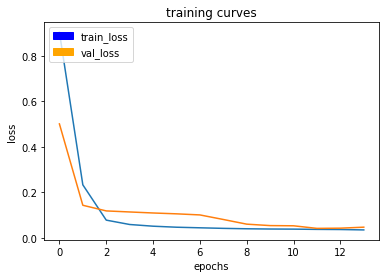

65/65 [==============================] - 187s - loss: 0.0348 - val_loss: 0.0468
Epoch 15/75
64/65 [============================>.] - ETA: 2s - loss: 0.0344

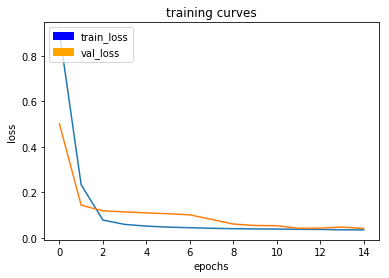

65/65 [==============================] - 188s - loss: 0.0345 - val_loss: 0.0405
Epoch 16/75
64/65 [============================>.] - ETA: 2s - loss: 0.0347

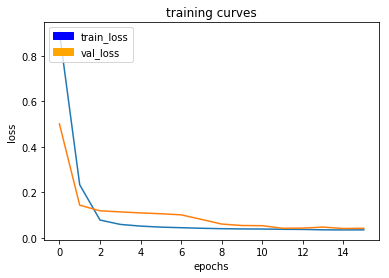

65/65 [==============================] - 188s - loss: 0.0346 - val_loss: 0.0417
Epoch 17/75
64/65 [============================>.] - ETA: 2s - loss: 0.0336

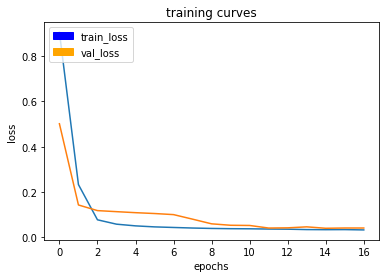

65/65 [==============================] - 188s - loss: 0.0335 - val_loss: 0.0416
Epoch 18/75
64/65 [============================>.] - ETA: 2s - loss: 0.0340

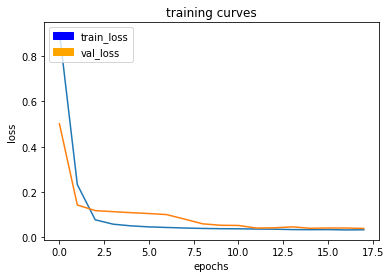

65/65 [==============================] - 188s - loss: 0.0339 - val_loss: 0.0398
Epoch 19/75
64/65 [============================>.] - ETA: 2s - loss: 0.0321

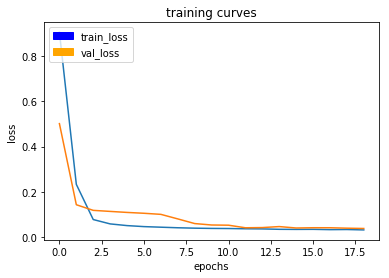

65/65 [==============================] - 188s - loss: 0.0320 - val_loss: 0.0384
Epoch 20/75
64/65 [============================>.] - ETA: 2s - loss: 0.0323

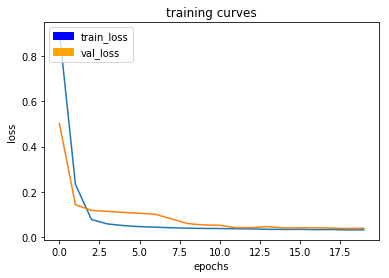

65/65 [==============================] - 188s - loss: 0.0323 - val_loss: 0.0396
Epoch 21/75
64/65 [============================>.] - ETA: 2s - loss: 0.0320

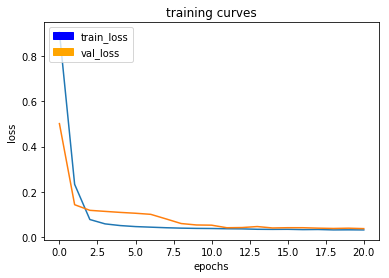

65/65 [==============================] - 188s - loss: 0.0319 - val_loss: 0.0377
Epoch 22/75
64/65 [============================>.] - ETA: 2s - loss: 0.0316

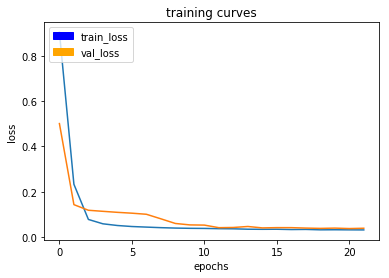

65/65 [==============================] - 188s - loss: 0.0316 - val_loss: 0.0390
Epoch 23/75
64/65 [============================>.] - ETA: 2s - loss: 0.0299

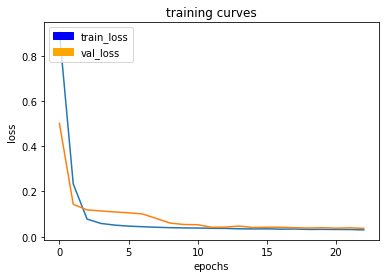

65/65 [==============================] - 189s - loss: 0.0298 - val_loss: 0.0368
Epoch 24/75
64/65 [============================>.] - ETA: 2s - loss: 0.0304

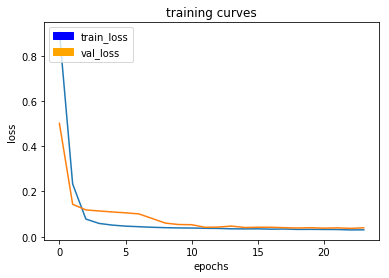

65/65 [==============================] - 188s - loss: 0.0303 - val_loss: 0.0391
Epoch 25/75
64/65 [============================>.] - ETA: 2s - loss: 0.0303

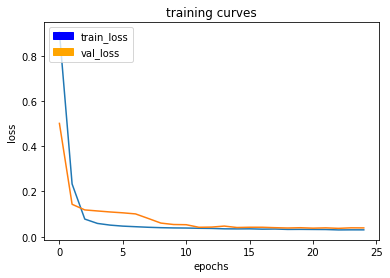

65/65 [==============================] - 188s - loss: 0.0302 - val_loss: 0.0388
Epoch 26/75
64/65 [============================>.] - ETA: 2s - loss: 0.0298

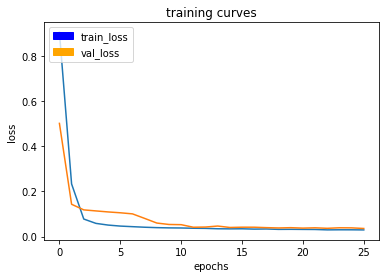

65/65 [==============================] - 188s - loss: 0.0297 - val_loss: 0.0360
Epoch 27/75
64/65 [============================>.] - ETA: 2s - loss: 0.0290

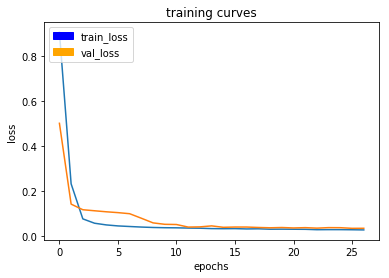

65/65 [==============================] - 188s - loss: 0.0289 - val_loss: 0.0362
Epoch 28/75
64/65 [============================>.] - ETA: 2s - loss: 0.0290

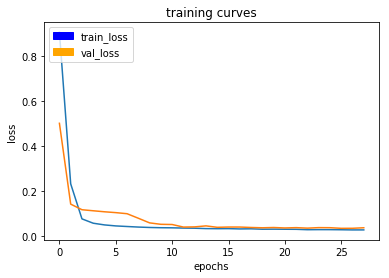

65/65 [==============================] - 188s - loss: 0.0290 - val_loss: 0.0385
Epoch 29/75
64/65 [============================>.] - ETA: 2s - loss: 0.0286

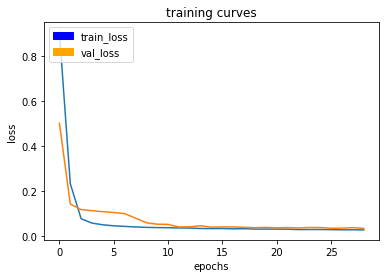

65/65 [==============================] - 188s - loss: 0.0285 - val_loss: 0.0349
Epoch 30/75
64/65 [============================>.] - ETA: 2s - loss: 0.0294

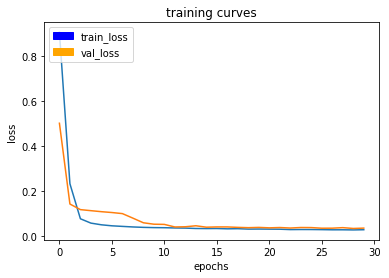

65/65 [==============================] - 188s - loss: 0.0293 - val_loss: 0.0364
Epoch 31/75
64/65 [============================>.] - ETA: 2s - loss: 0.0284

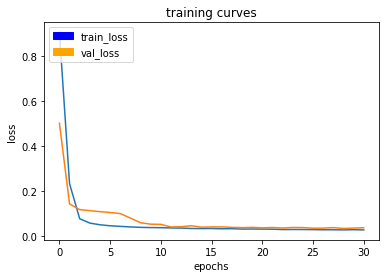

65/65 [==============================] - 188s - loss: 0.0283 - val_loss: 0.0381
Epoch 32/75
64/65 [============================>.] - ETA: 2s - loss: 0.0294

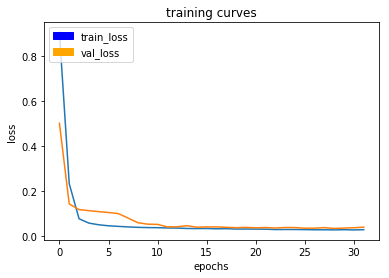

65/65 [==============================] - 188s - loss: 0.0295 - val_loss: 0.0404
Epoch 33/75
64/65 [============================>.] - ETA: 2s - loss: 0.0275

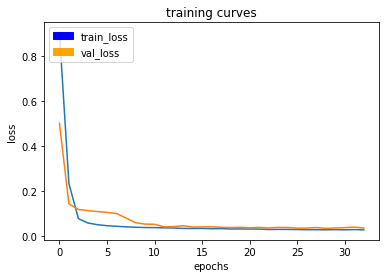

65/65 [==============================] - 188s - loss: 0.0280 - val_loss: 0.0362
Epoch 34/75
64/65 [============================>.] - ETA: 2s - loss: 0.0278

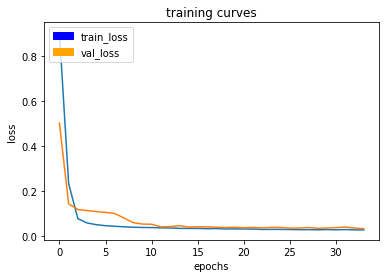

65/65 [==============================] - 189s - loss: 0.0278 - val_loss: 0.0333
Epoch 35/75
64/65 [============================>.] - ETA: 2s - loss: 0.0271

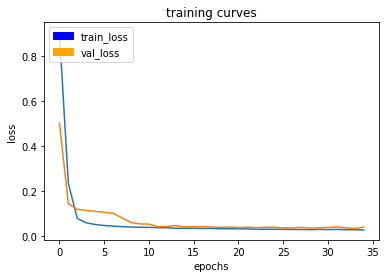

65/65 [==============================] - 188s - loss: 0.0270 - val_loss: 0.0396
Epoch 36/75
64/65 [============================>.] - ETA: 2s - loss: 0.0274

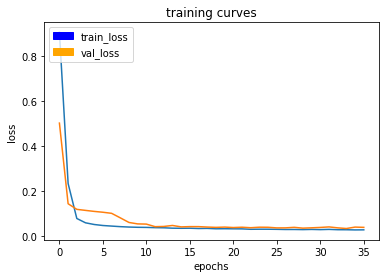

65/65 [==============================] - 188s - loss: 0.0274 - val_loss: 0.0384
Epoch 37/75
64/65 [============================>.] - ETA: 2s - loss: 0.0268

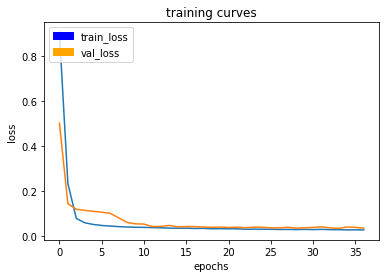

65/65 [==============================] - 188s - loss: 0.0269 - val_loss: 0.0349
Epoch 38/75
64/65 [============================>.] - ETA: 2s - loss: 0.0269

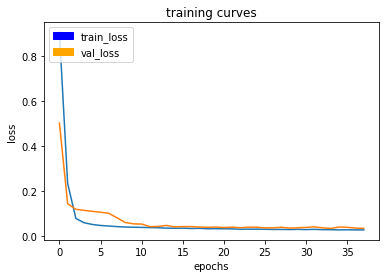

65/65 [==============================] - 188s - loss: 0.0269 - val_loss: 0.0340
Epoch 39/75
64/65 [============================>.] - ETA: 2s - loss: 0.0263

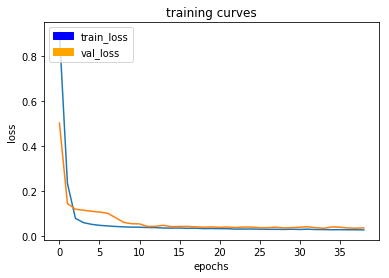

65/65 [==============================] - 188s - loss: 0.0263 - val_loss: 0.0353
Epoch 40/75
64/65 [============================>.] - ETA: 2s - loss: 0.0260

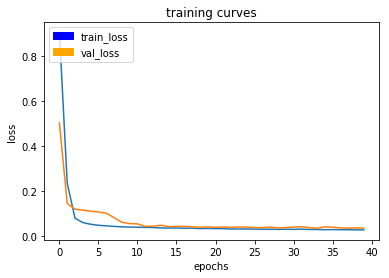

65/65 [==============================] - 188s - loss: 0.0260 - val_loss: 0.0336
Epoch 41/75
64/65 [============================>.] - ETA: 2s - loss: 0.0259

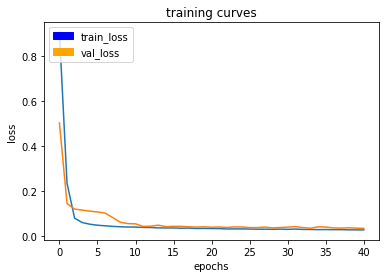

65/65 [==============================] - 188s - loss: 0.0258 - val_loss: 0.0327
Epoch 42/75
64/65 [============================>.] - ETA: 2s - loss: 0.0263

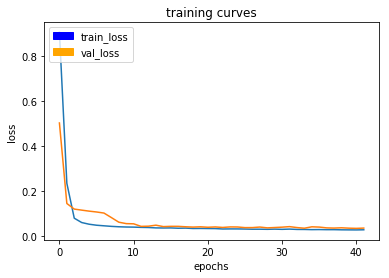

65/65 [==============================] - 188s - loss: 0.0264 - val_loss: 0.0339
Epoch 43/75
64/65 [============================>.] - ETA: 2s - loss: 0.0257

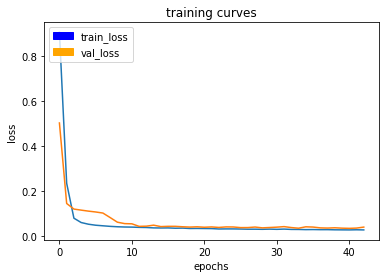

65/65 [==============================] - 188s - loss: 0.0258 - val_loss: 0.0382
Epoch 44/75
64/65 [============================>.] - ETA: 2s - loss: 0.0269

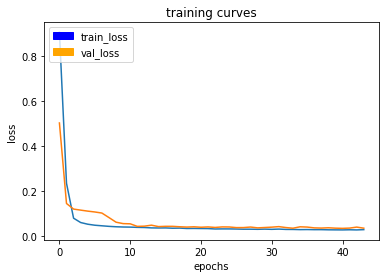

65/65 [==============================] - 188s - loss: 0.0270 - val_loss: 0.0335
Epoch 45/75
64/65 [============================>.] - ETA: 2s - loss: 0.0255

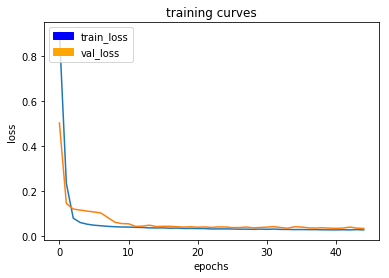

65/65 [==============================] - 188s - loss: 0.0257 - val_loss: 0.0324
Epoch 46/75
64/65 [============================>.] - ETA: 2s - loss: 0.0259

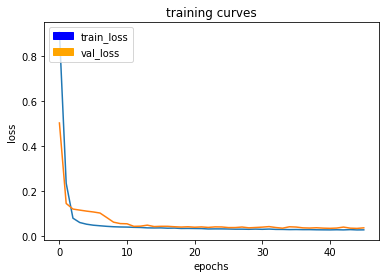

65/65 [==============================] - 188s - loss: 0.0259 - val_loss: 0.0349
Epoch 47/75
64/65 [============================>.] - ETA: 2s - loss: 0.0248

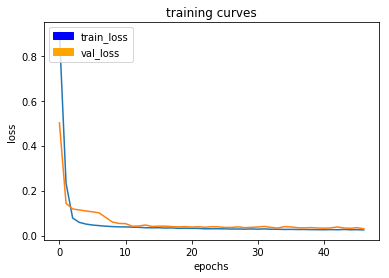

65/65 [==============================] - 188s - loss: 0.0250 - val_loss: 0.0301
Epoch 48/75
64/65 [============================>.] - ETA: 2s - loss: 0.0250

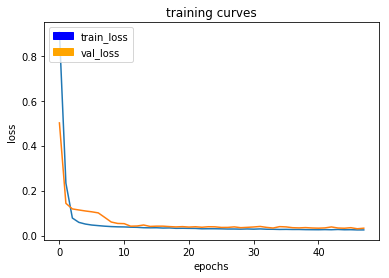

65/65 [==============================] - 188s - loss: 0.0250 - val_loss: 0.0326
Epoch 49/75
64/65 [============================>.] - ETA: 2s - loss: 0.0251

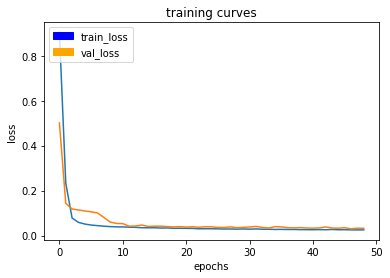

65/65 [==============================] - 188s - loss: 0.0251 - val_loss: 0.0322
Epoch 50/75
64/65 [============================>.] - ETA: 2s - loss: 0.0247

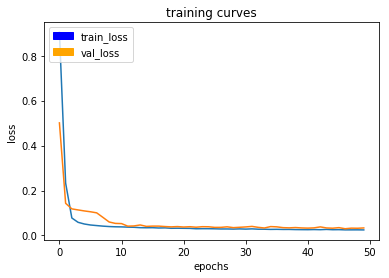

65/65 [==============================] - 188s - loss: 0.0248 - val_loss: 0.0336
Epoch 51/75
64/65 [============================>.] - ETA: 2s - loss: 0.0241

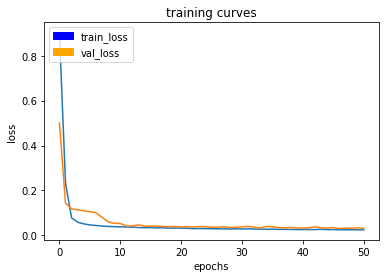

65/65 [==============================] - 188s - loss: 0.0245 - val_loss: 0.0314
Epoch 52/75
64/65 [============================>.] - ETA: 2s - loss: 0.0253

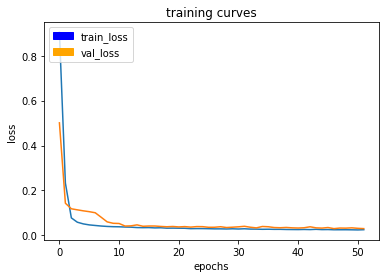

65/65 [==============================] - 188s - loss: 0.0252 - val_loss: 0.0301
Epoch 53/75
64/65 [============================>.] - ETA: 2s - loss: 0.0241

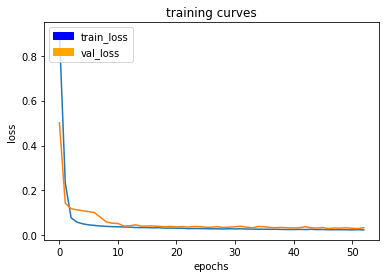

65/65 [==============================] - 189s - loss: 0.0241 - val_loss: 0.0337
Epoch 54/75
64/65 [============================>.] - ETA: 2s - loss: 0.0237

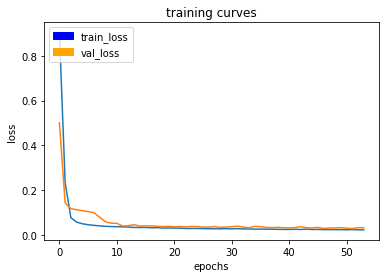

65/65 [==============================] - 188s - loss: 0.0237 - val_loss: 0.0334
Epoch 55/75
64/65 [============================>.] - ETA: 2s - loss: 0.0250

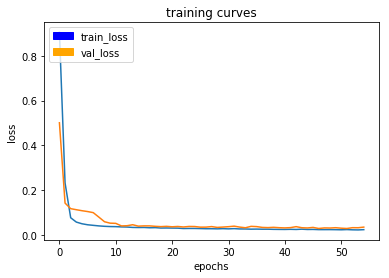

65/65 [==============================] - 188s - loss: 0.0249 - val_loss: 0.0362
Epoch 56/75
64/65 [============================>.] - ETA: 2s - loss: 0.0258

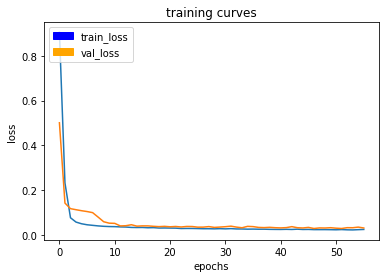

65/65 [==============================] - 188s - loss: 0.0257 - val_loss: 0.0323
Epoch 57/75
64/65 [============================>.] - ETA: 2s - loss: 0.0246

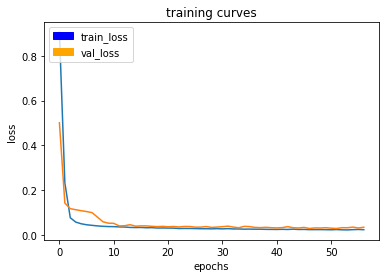

65/65 [==============================] - 187s - loss: 0.0246 - val_loss: 0.0357
Epoch 58/75
64/65 [============================>.] - ETA: 2s - loss: 0.0236

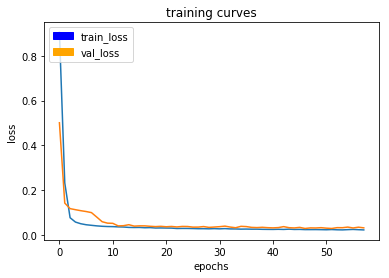

65/65 [==============================] - 188s - loss: 0.0236 - val_loss: 0.0328
Epoch 59/75
64/65 [============================>.] - ETA: 2s - loss: 0.0240

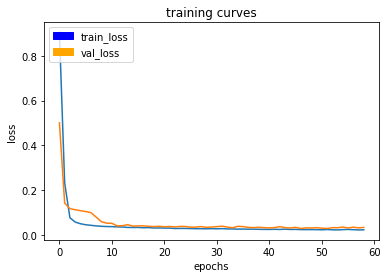

65/65 [==============================] - 187s - loss: 0.0240 - val_loss: 0.0346
Epoch 60/75
64/65 [============================>.] - ETA: 2s - loss: 0.0232

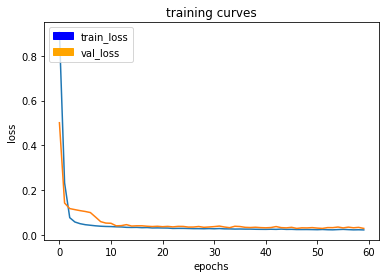

65/65 [==============================] - 188s - loss: 0.0233 - val_loss: 0.0300
Epoch 61/75
64/65 [============================>.] - ETA: 2s - loss: 0.0234

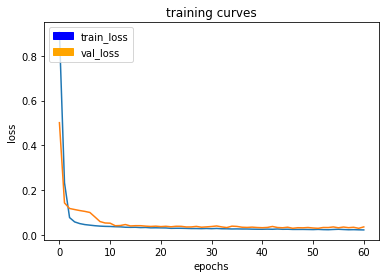

65/65 [==============================] - 188s - loss: 0.0234 - val_loss: 0.0363
Epoch 62/75
64/65 [============================>.] - ETA: 2s - loss: 0.0259

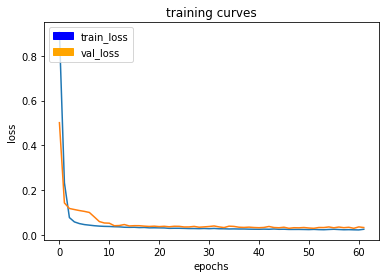

65/65 [==============================] - 188s - loss: 0.0258 - val_loss: 0.0334
Epoch 63/75
64/65 [============================>.] - ETA: 2s - loss: 0.0231

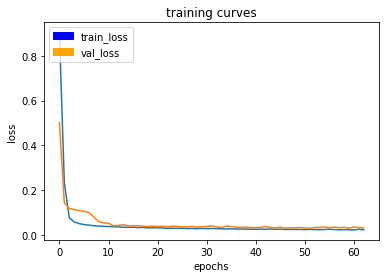

65/65 [==============================] - 188s - loss: 0.0231 - val_loss: 0.0314
Epoch 64/75
64/65 [============================>.] - ETA: 2s - loss: 0.0236

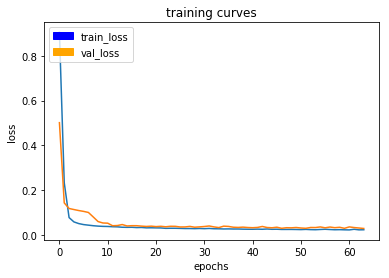

65/65 [==============================] - 188s - loss: 0.0235 - val_loss: 0.0293
Epoch 65/75
64/65 [============================>.] - ETA: 2s - loss: 0.0237

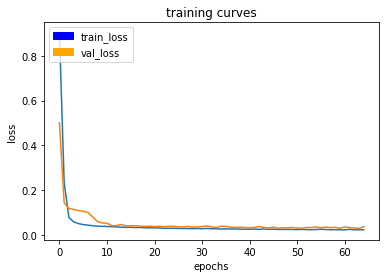

65/65 [==============================] - 188s - loss: 0.0237 - val_loss: 0.0372
Epoch 66/75
64/65 [============================>.] - ETA: 2s - loss: 0.0236

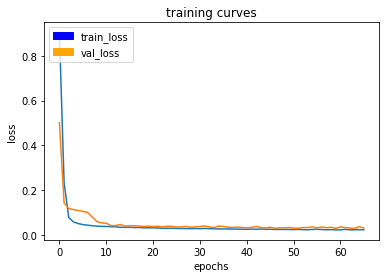

65/65 [==============================] - 188s - loss: 0.0236 - val_loss: 0.0314
Epoch 67/75
64/65 [============================>.] - ETA: 2s - loss: 0.0228

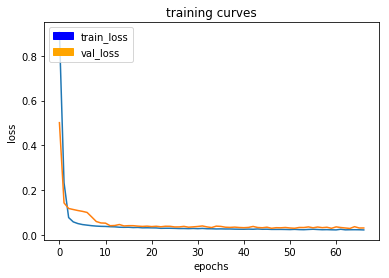

65/65 [==============================] - 188s - loss: 0.0227 - val_loss: 0.0314
Epoch 68/75
64/65 [============================>.] - ETA: 2s - loss: 0.0224

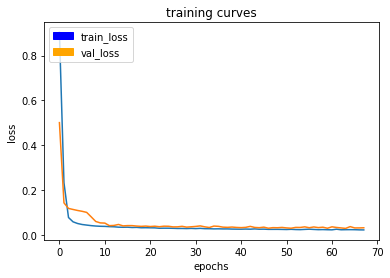

65/65 [==============================] - 188s - loss: 0.0225 - val_loss: 0.0320
Epoch 69/75
64/65 [============================>.] - ETA: 2s - loss: 0.0229

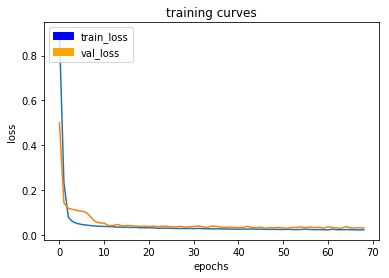

65/65 [==============================] - 188s - loss: 0.0229 - val_loss: 0.0306
Epoch 70/75
64/65 [============================>.] - ETA: 2s - loss: 0.0229

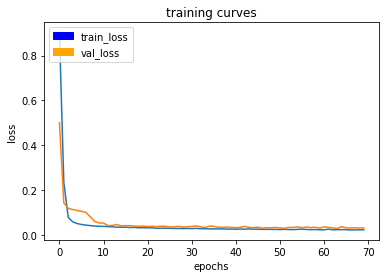

65/65 [==============================] - 188s - loss: 0.0229 - val_loss: 0.0317
Epoch 71/75
64/65 [============================>.] - ETA: 2s - loss: 0.0219

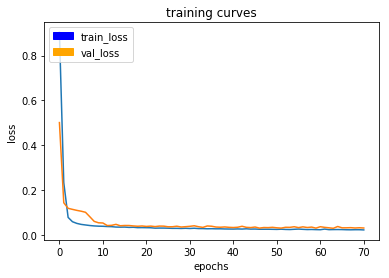

65/65 [==============================] - 188s - loss: 0.0219 - val_loss: 0.0305
Epoch 72/75
64/65 [============================>.] - ETA: 2s - loss: 0.0223

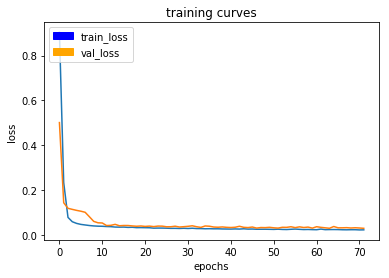

65/65 [==============================] - 188s - loss: 0.0223 - val_loss: 0.0291
Epoch 73/75
64/65 [============================>.] - ETA: 2s - loss: 0.0223

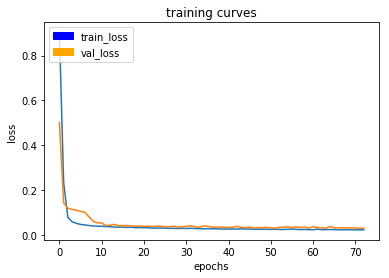

65/65 [==============================] - 188s - loss: 0.0223 - val_loss: 0.0297
Epoch 74/75
64/65 [============================>.] - ETA: 2s - loss: 0.0222

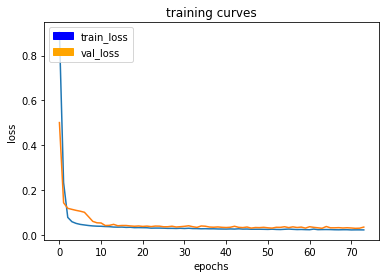

65/65 [==============================] - 188s - loss: 0.0221 - val_loss: 0.0346
Epoch 75/75
64/65 [============================>.] - ETA: 2s - loss: 0.0232

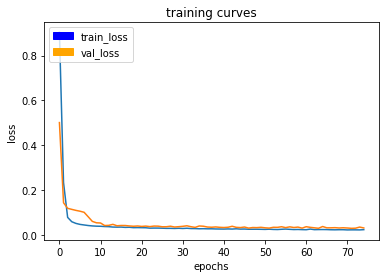

65/65 [==============================] - 187s - loss: 0.0231 - val_loss: 0.0308


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'dl_aws_run3_model_weights'
model_tools.save_network(model, weight_file_name)

run 1 
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 8

~120s per run

run 2 
learning_rate = 0.001
batch_size = 64
num_epochs = 100
steps_per_epoch = 65
validation_steps = 50
workers = 8

~120s per run
seems to overfit

run3
learning_rate = 0.001
batch_size = 64
num_epochs = 75
steps_per_epoch = 65
validation_steps = 50
workers = 8


## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'dl_aws_run_3'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

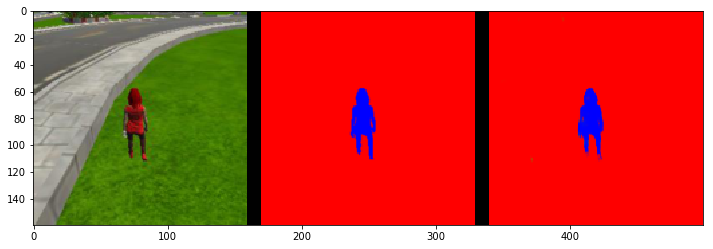

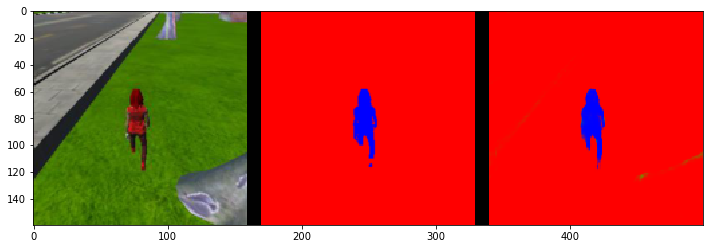

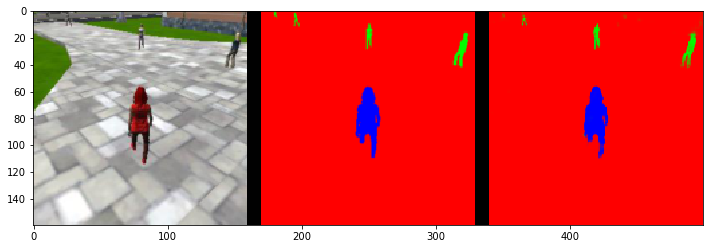

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

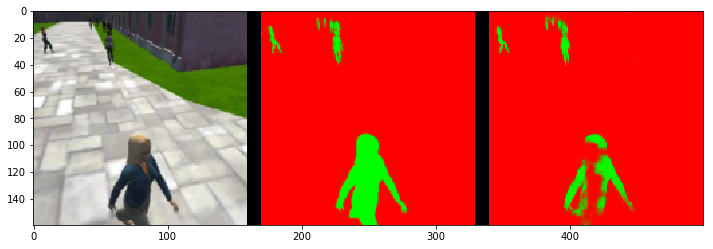

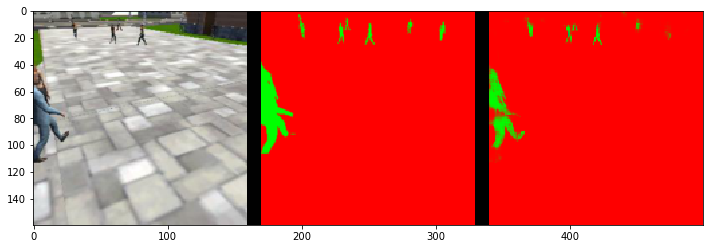

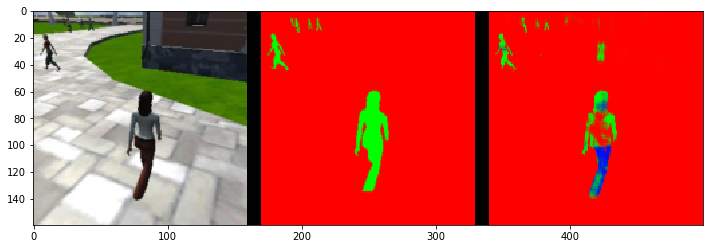

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

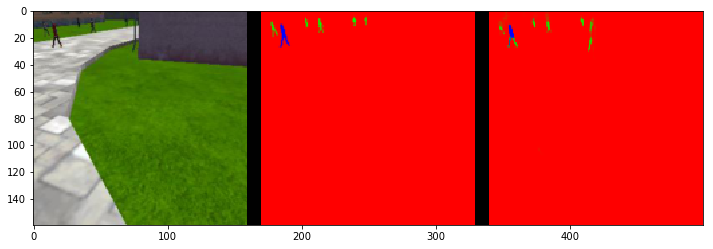

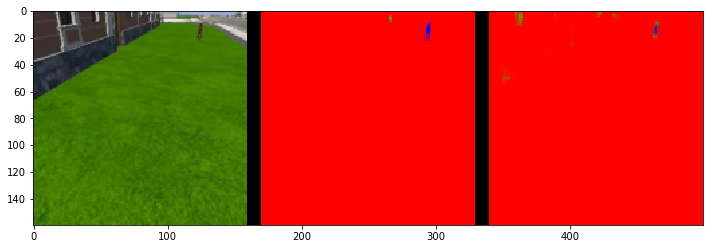

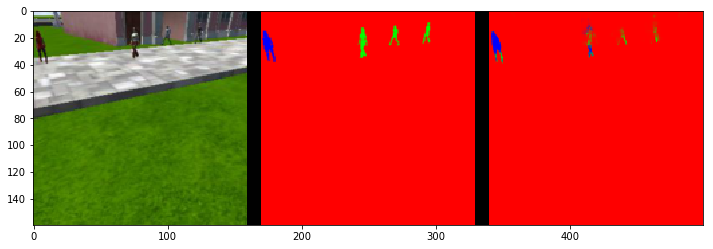

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9946620302871529
average intersection over union for other people is 0.3145492759583945
average intersection over union for the hero is 0.8717430706478739
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9786364625355646
average intersection over union for other people is 0.5545149349387023
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 77, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9955648497191975
average intersection over union for other people is 0.3972070855020659
average intersection over union for the hero is 0.2524583626080155
number true positives: 164, number false positives: 1, number false negatives: 137


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7657952069716776


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.562100716628


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.430454034629
